## **Probability and Statistics**


The journey into Statistics this week can be distilled into the following objectives:

a) Conduct Quantitative Data Analysis

b) Perform Graphical Data Analysis

c) Use Statistical Techniques to make quantitative statements on data (encompassing discrete and continuous variables)



In this Sprint Challenge, we are going to use the "Loans" data set. The data set contains information about applicants who have applied for home loans, their monthly incomes, the loan amount (in 000's) the property type they are seeking, Credit History (0 indicates no credit history) and their associated loan status.



The dataset can be retrieved from here: https://www.dropbox.com/s/nmo9vweoscsg328/Loan_Dataset.csv?raw=1

Create solutions for the following code blocks. This exercise should take ~ 3 hours.

Share with mlsubmissions@lambdaschool.com when finished.


In [0]:
# LAMBDA SCHOOL
#
# MACHINE LEARNING
#
# MIT LICENSE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import spearmanr, chi2_contingency
from sklearn.preprocessing import LabelEncoder

## Step 1: Examine the data set for any missing values

In [2]:
data = pd.read_csv('https://www.dropbox.com/s/nmo9vweoscsg328/Loan_Dataset.csv?raw=1')
print(data.shape)
print(data.isnull().any())

(614, 13)
LoanID               False
Gender                True
Married               True
Dependents            True
Education            False
Self_Employed         True
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount            True
Loan_Amount_Term      True
CreditHistory         True
PropertyArea         False
LoanStatus           False
dtype: bool


## Step 2: If there are any missing values, treat the misisng values. 

Here is a article that provides insight into the common methods to deal with missing values:

https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce

Please use the tips provided in the article to deal with missing values

Out of the columns with missing values, `'Gender'`, `'Married'`, `'Dependents'`, `'Self_Employed'`, and `'CreditHistory'` are clearly categorical, while `'LoanAmount'` is numeric. `'Loan_Amount_Term'` is numeric, but is in large intervals.

I will use the median value in `'LoanAmount'` to fill its missing values, and the most frequent value for the remaining columns.

In [0]:
def fill_mixed_median_mode(dataframe, medians=list()):
    """ Fill missing values with median for specified column, otherwise mode
    
    Args:
        dataframe (pandas.core.frame.DataFrame): rows of observations of features
        medians (list): columns to fill missing values with median instead of mode
        
    Returns:
        dataframe with no missing values
    """
    
    
    null = dataframe.isnull().any()
    null_cols = list(null[null].index)
    
    fill = pd.Series([data[c].median() if c in medians else data[c].mode()[0]
                     for c in null_cols], index=null_cols)
    
    dataframe[null_cols] = dataframe[null_cols].fillna(fill)
    return dataframe

In [4]:
data_f = fill_mixed_median_mode(data, ['LoanAmount'])
print("Any Remaining Nulls:", data_f.isnull().any().any())
data_f.head()

Any Remaining Nulls: False


,LoanID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,CreditHistory,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Step 3: Conduct Quantitative Data Analysis

Compute summary statistics (i.e. Mean, Median, Standard Deviation, Variance) for:

* Applicant Income
* Total Income = Applicant Income + Coapplicant Income
* Loan Amount
* Loan Term

First I calculate the total income, and store it as a `Series` so that I can join it to the data. Indexing into the resulting `DataFrame` using double square brackets is helpful because it returns another `DataFrame` with the columns in the order I desire.

In [5]:
total_income = pd.Series(data_f['ApplicantIncome'] + data_f['CoapplicantIncome'], name='TotalIncome')


data_selected = data_f.join(total_income)[['ApplicantIncome', 'TotalIncome', 'LoanAmount', 'Loan_Amount_Term']]
data_selected.head()

,ApplicantIncome,TotalIncome,LoanAmount,Loan_Amount_Term
0,5849,5849.0,128.0,360.0
1,4583,6091.0,128.0,360.0
2,3000,3000.0,66.0,360.0
3,2583,4941.0,120.0,360.0
4,6000,6000.0,141.0,360.0


The mean, and standard deviation are all summary statistics included in the ['.describe'](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) method of dataframes. I can calculate the variance from the standard deviation simply by squaring the later. I use [`np.power`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.power.html) instead of the `**` operator to ensure that the operation broadcasts consistently and predictably.

In [6]:
summary = data_selected.describe().loc[['mean', '50%', 'std']]

variance = pd.Series(np.power(summary.loc['std'], 2), name='variance')
summary = summary.append(variance)

summary

,ApplicantIncome,TotalIncome,LoanAmount,Loan_Amount_Term
mean,5.403459e+03,7.024705e+03,145.752443,342.410423
50%,3.812500e+03,5.416500e+03,128.000000,360.000000
std,6.109042e+03,6.458664e+03,84.107233,64.428629
variance,3.732039e+07,4.171434e+07,7074.026707,4151.048244


## Step 4: Perform Graphical Data Analysis:

a) Contruct an ECDF to analyze the distribution of 
* Applicant Income
* Total Income = Applicant Income + Coapplicant Income
* Loan Amount
* Loan Term

b) Overlay each of the ECDF plots with markers (i.e. Diamonds) depicting the corresponding 25th, 50th and 75th percentiles respectively

c) Build Histograms to examine the distribution of:
* Applicant Income
* Total Income = Applicant Income + Coapplicant Income
* Loan Amount
* Loan Term

d) Create BoxPlots to understand the distribution of:
* Application Income By Gender of Applicant
* Application Income By Education of Applicant
* Application Income by Employment Type
* Loan Amount by Gender of Applicant
* Loan Amount by Education of Applicant
* Loan Amount by Employment Type

e) Construct Bee Swarm Plots to analyze the distribution of:
* Application Income By Gender of Applicant
* Application Income By Education of Applicant
* Application Income by Employment Type
* Loan Amount by Gender of Applicant
* Loan Amount by Education of Applicant
* Loan Amount by Employment Type

f) Plot a Stacked Bar Chart showcasing Count of Applicants by Loan Status and Gender. The Gender attribute is color coded within the stacked bar chart

In [0]:
data_selected = data_f.join(total_income)[['Gender', 'Education', 'Self_Employed', 
                                           'ApplicantIncome', 'TotalIncome', 
                                           'LoanAmount', 'Loan_Amount_Term', 'LoanStatus']]

In [0]:
def ecdf_plots(data, features, plot_cols=2, quartile_markers=False):
    """Plot a grid of ECDFs for numeric data
    
    Args:
        data (pd.core.frame.DataFrame)
        features (iterable): names of numeric columns of data
        plot_cols (int): number of columns for subplot grid
        quartile_markers (bool): whether to plot the quartiles with the ecdf
        
    Returns:
        fig: matplotlib.figure.Figure object
        axs: array of Axes objects.
    
    """
    
    plot_rows = int(np.ceil(len(features) / plot_cols))
    
    fig, axs = plt.subplots(plot_rows, plot_cols)
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle('Empirical Cumulative Distribution Functions')
    
    for ix, feature in enumerate(features):
        selection = data[feature]
        
        p0 = ix // plot_cols
        p1 = ix % plot_cols
        
        ecdf = ECDF(selection)
        x = np.linspace(selection.min(), selection.max())
        y = ecdf(x)
        
        axs[p0, p1].step(x, y)
        axs[p0, p1].set(title=feature)
        
        if quartile_markers:
            quartiles = selection.describe().loc[['25%', '50%', '75%']]
            
            for q in quartiles:
                qy = ecdf(q)
                axs[p0, p1].plot(q, qy, 'kD')
        
    return fig, axs

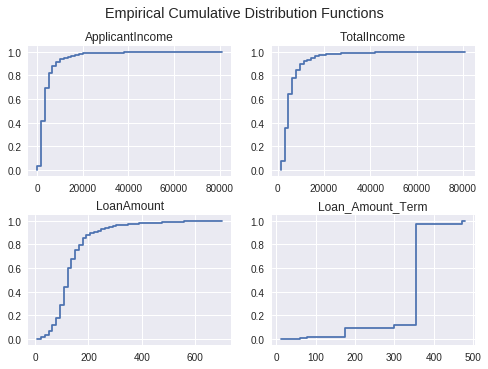

In [9]:
features = ['ApplicantIncome', 'TotalIncome', 'LoanAmount', 'Loan_Amount_Term']

ecdf_plots(data_selected, features);

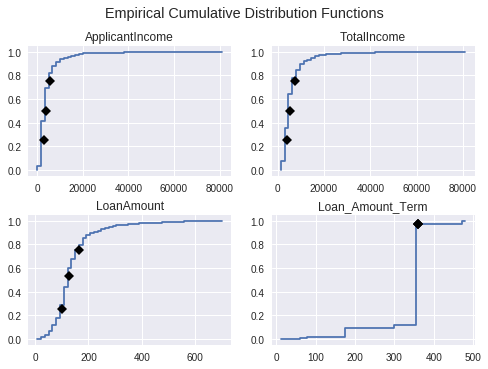

In [10]:
ecdf_plots(data_selected, features, quartile_markers=True);

Because of the presence of outliers, simple histograms do not look very good. For plotting the empirical distribution of data, I favor [`sns.distplot`](https://seaborn.pydata.org/generated/seaborn.distplot.html) which overlays a kernel density estimation on a histogram.

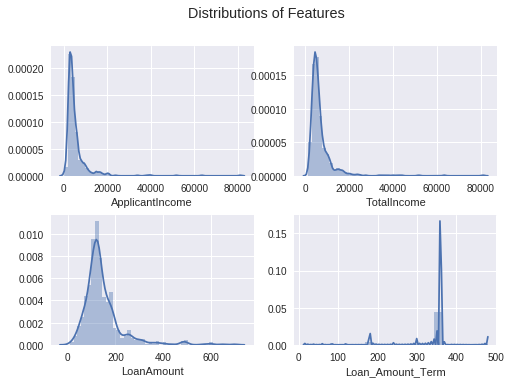

In [16]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Distributions of Features')
fig.subplots_adjust(hspace=0.3)

for ix, feature in enumerate(data_selected[features]):
    p0 = ix // 2
    p1 = ix % 2
    
    sns.distplot(data_selected[feature], ax=axs[p0, p1])
    

In [0]:
def spread_plot(data, features, groups, plot=sns.boxplot):
    fig, axs = plt.subplots(len(groups), len(features))
    fig.subplots_adjust(hspace=0.3)
    
    for ix, group in enumerate(groups):
        for iy, feature in enumerate(features):
            
            plot(x=data[group], y=data[feature], ax=axs[ix, iy])
            
    return fig, axs

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


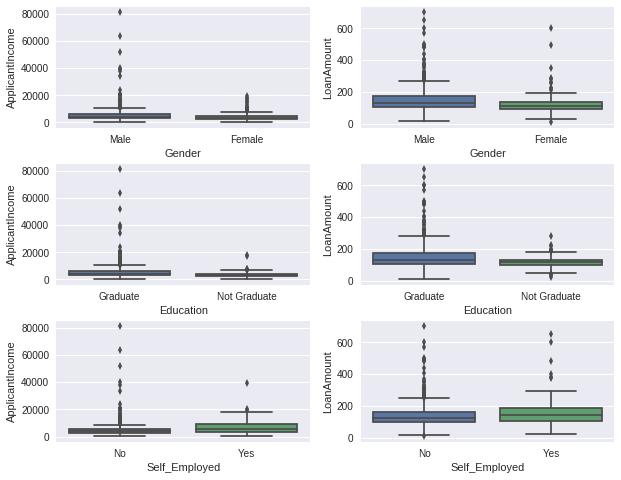

In [36]:
features = ['ApplicantIncome', 'LoanAmount']
groups = ['Gender', 'Education', 'Self_Employed']

fig, axs = spread_plot(data_selected, features, groups)
fig.set_size_inches(10, 8)

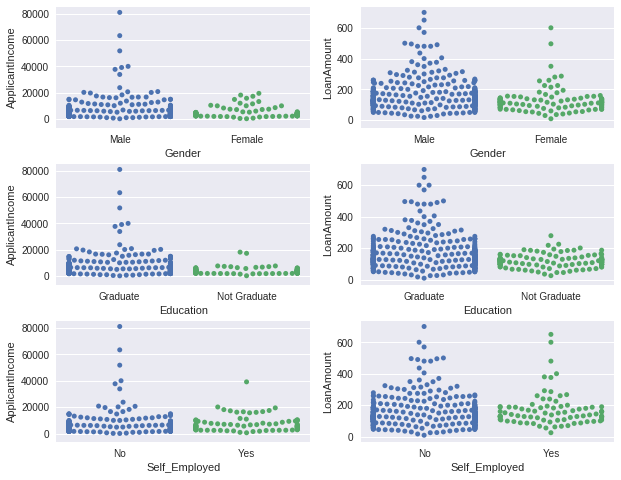

In [41]:
fig, axs = spread_plot(data_selected, features, groups, plot=sns.swarmplot)
fig.set_size_inches(10, 8)

In [76]:
plotdata = data_selected.groupby(['Gender', 'LoanStatus']).count().unstack()[['Education']].reset_index()
plotdata.columns = ['Gender', 'N', 'Y']
plotdata

,Gender,N,Y
0,Female,37,75
1,Male,155,347


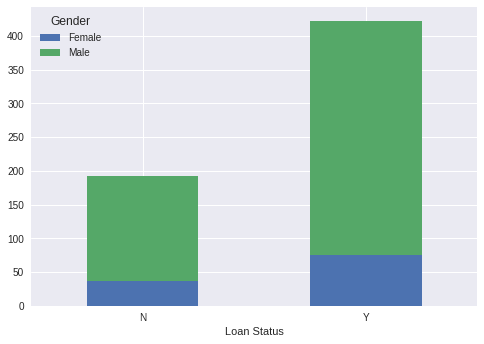

In [81]:
ax = plotdata.set_index('Gender').T.plot(kind='bar', stacked=True, rot=0)
ax.set(xlabel='Loan Status');

## Step 5: Compute the chances of securing/getting a loan based on Credit History

Hint: Will require the use of the crosstab function

In [84]:
crosstab = pd.crosstab(data_f['LoanStatus'], data_f['CreditHistory'])
crosstab

CreditHistory,0.0,1.0
LoanStatus,,
N,82,110
Y,7,415


In [89]:
credit_0_chances = crosstab[0.0].loc['Y'] / crosstab[0.0].sum()
credit_1_chances = crosstab[1.0].loc['Y'] / crosstab[1.0].sum()

print('The probability of securing a loan given CreditHistory=0.0 is {:.4f}'.format(credit_0_chances))
print('The probability of securing a loan given CreditHistory=1.0 is {:.4f}'.format(credit_1_chances))

The probability of securing a loan given CreditHistory=0.0 is 0.0787
The probability of securing a loan given CreditHistory=1.0 is 0.7905


## Step 6: Use Statistical Techniques to make quantitative statements on data

**1)** Detect relationships in the Loan dataset. 

For example: 

a) Does the 'Applicant Income' and the 'Loan Amount' vary together? Construct a scatter plot that plots the 'Applicant Income' v/s "Loan Amount"'. Does the Scatter Plot point to a positive covariance? Now, compute the Covariance. 

b) Does the 'Total Income' and the 'Loan Amount' vary together? Construct a scatter plot that plots the 'Total Income' v/s "Loan Amount"'. Does the Scatter Plot point to a positive covariance? Now, compute the Covariance.

c) Are there any other variables that vary together? Construct a scatter plot that plots the respective variables. Does the Scatter Plot point to a positive covariance? Now, compute the Covariance.


**2)** Gauge the strength of the relationships

For example:

a) Compute the Correlation Coefficient between the 2 variable i.e. 'Applicant Income' and the 'Loan Amount'.

b) Compute the Correlation Coefficient between the 2 variable i.e. 'Total Income' and the 'Loan Amount'.
 
c) Compute the Correlation Coefficient between the pair of variables you have identied
  

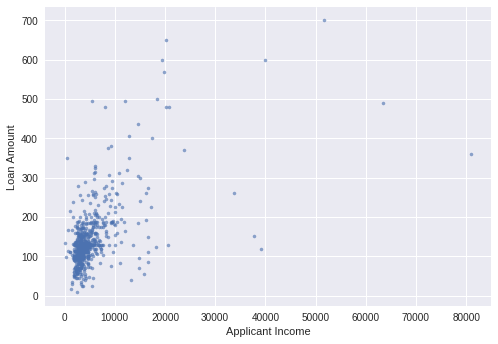

In [102]:
fig, ax = plt.subplots()

ax.scatter(data_f['ApplicantIncome'], data_f['LoanAmount'], s=10, alpha=0.6)
ax.set(xlabel='Applicant Income', ylabel='Loan Amount');

The scatter plot indicates that as `ApplicantIncome` increases, `LoanAmount` also increases. Therefore, we expect them to have positive covariance. The correlation coefficient will be the covariance scaled down by the product of the individual variances of the data, thus being between 0 and 1. We expect this to also be positive.

In [0]:
def scatter(data, x, y):
    fig, ax = plt.subplots()

    ax.scatter(data[x], data[y], s=10, alpha=0.6)
    ax.set(xlabel=x, ylabel=y)
    
    return fig, ax

def compute_cov_corr(data, feature1, feature2):
    M = data[[feature1, feature2]].as_matrix().T
    
    cov = np.cov(M)[0, 1]
    corr = np.corrcoef(M)[0, 1]
    
    return cov, corr

In [107]:
cov, corr = compute_cov_corr(data_f, 'ApplicantIncome', 'LoanAmount')

print('Covariance: {:.4f}, Correlation: {:.4f}'.format(cov, corr))

Covariance: 290397.9981, Correlation: 0.5652


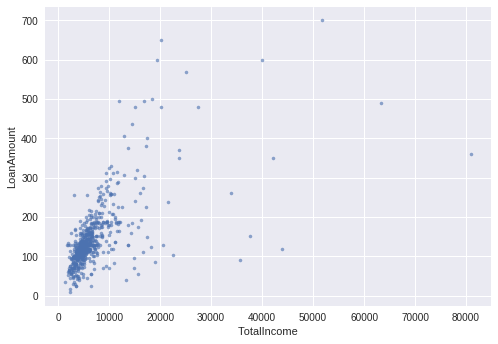

In [139]:
scatter(data_selected, 'TotalIncome', 'LoanAmount');

`LoanAmount` is also positively correlated with `TotalIncome`. This is expected, since `TotalIncome` is represents a the element-wise sum of relatively small numbers with the elements of `ApplicantIncome`.

In [108]:
cov, corr = compute_cov_corr(data_selected, 'TotalIncome', 'LoanAmount')

print('Covariance: {:.4f}, Correlation: {:.4f}'.format(cov, corr))

Covariance: 336968.0240, Correlation: 0.6203


We can plot a heatmap to visualize the entire correlation matrix. Though I've been using the Numpy's [`corrcoef`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.corrcoef.html), it is also possible to use the [`corr`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method of dataframes.

In [0]:
def correlation_heatmap(corr_data, labels='auto'):
    """Visualize the correlation matrix of a dataframe as a heatmap
    https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    """
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=(19, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio    
    sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                ax=ax, yticklabels=labels, xticklabels=labels)
    
    return fig, ax

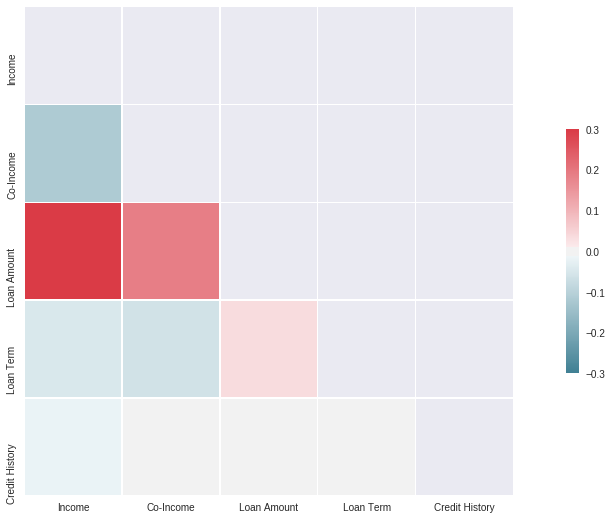

In [173]:
labels = ['Income', 'Co-Income', 'Loan Amount', 'Loan Term', 'Credit History']

correlation_heatmap(data_f.corr(), labels=labels);

The only promising relationship seems to be a negative correlation between `ApplicantIncome` and `CoapplicantIncome`.

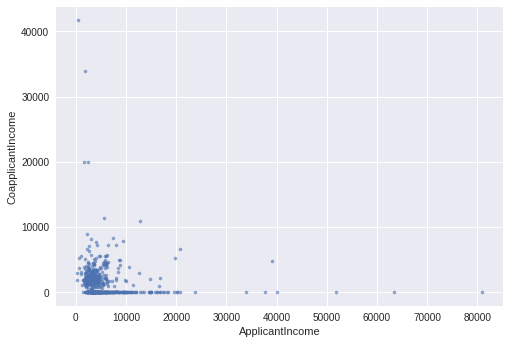

In [142]:
scatter(data_f, 'ApplicantIncome', 'CoapplicantIncome');

It seems that applicants with higher income either have coapplicants with low income or do not report their coapplicant's income. The same also appears to be true for applicants with low income with high-income coapplicants. Applicants with low income often have similar incomes to their coapplicants, but also frequently report zero coapplicant income.

In [137]:
cov, corr = compute_cov_corr(data_f, 'ApplicantIncome', 'CoapplicantIncome')

print('Covariance: {:.4f}, Correlation: {:.4f}'.format(cov, corr))

Covariance: -2084490.3358, Correlation: -0.1166


## Step 7: Use Statistical Techniques to make quantitative statements on data. 

We will use a) Spearman's Rank Correlation, b) Chi-Square tables

1) Detect relationships amongst categorical, non-linearly related and non-normally distributed variables in the Loan dataset

For example: 

  a) Construct a Scatter Plot of 'Loan Term' amd 'Credit History' to verify that the variables are related non-linearly. Create a Histogram for "Loan Term" and 'Credit History' to ascertain that they are 
     not-normally distributed. A visual examination of the data proves that 'Loan Term' and 'Credit History' are numeric variables that can be placed in categories.

  b) Compute the Spearman's Rank Correlation Coefficient

  c) Conduct the Chi-Square test to ascertain how the 'Loan Term' variable is related to 'Credit History'

2) Use Spearman's Rank to find the correlation between **other ** categorical, non-linearly related and non-normally distributed variables.

*Hint*: There are categorical variables in the dataset that can be coded as numeric values i.e. 0,1

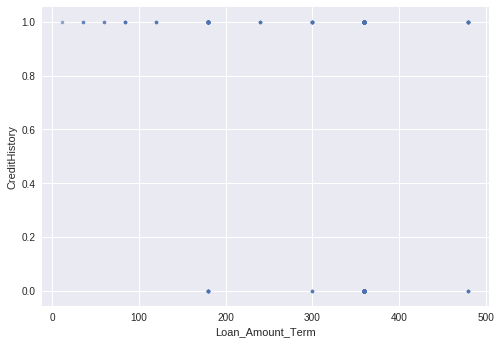

In [144]:
scatter(data_f, 'Loan_Amount_Term', 'CreditHistory');

The variables are indeed nonlinear, and both are categorical.

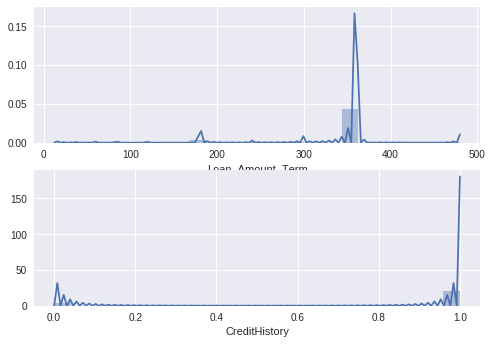

In [156]:
fig, axs = plt.subplots(2)

for ix, d in enumerate(['Loan_Amount_Term', 'CreditHistory']):
    sns.distplot(data_f[d], ax=axs[ix])


The variables are clearly not normally distributed.

In [160]:
M = data_f[['Loan_Amount_Term', 'CreditHistory']].as_matrix()
rho, prho = spearmanr(M)

counts = pd.crosstab(data_f['Loan_Amount_Term'], data_f['CreditHistory'])
chi2, pchi = chi2_contingency(counts)[:2]

print("Rank Correlation: {:.4f}, Chi-Square: {:.4f}, p-value: {:.4f}".format(rho, chi2, pchi))

Rank Correlation: 0.0071, Chi-Square: 7.9600, p-value: 0.5382


Based on these calculated Rank Correlation coefficient, we can say that the relationship between `Loan_Amount_Term` and `CreditHistory` is not very monotonic - one does not always increase as the other does. Furthermore, we cannot reject the null hypothesis that the two variables are independent of one another, based on the results of the Chi-Squared test.

In [161]:
data_f.head()

,LoanID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,CreditHistory,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Examining the data, `Gender`, `Married`, `Dependents`, `Education`, `Self_Employed`, `Loan_Amount_Term`, `CreditHistory`, `PropertyArea`, and `LoanStatus` are categorical. We can first plot a heatmap of their rank correlation coefficients, before confirming that the promising pairs of variables are nonlinearly related, and non-normally distributed.

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


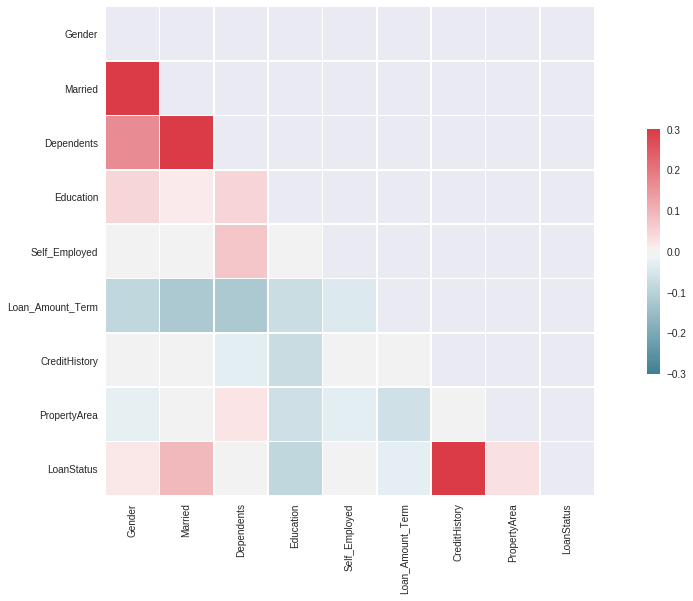

In [180]:
variables = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
             'Loan_Amount_Term', 'CreditHistory', 'PropertyArea', 'LoanStatus']

data_categorical = data_f[variables]

corr = spearmanr(data_categorical.as_matrix())[0]

correlation_heatmap(corr, variables);

The strongest positive correlations appear to be between `Married` and `Gender`, `Married` and `Dependents`, `CreditHistory` and `LoanStatus` and `Dependents` and `Gender`.

`Loan_Amount_Term` seems to be weakly negatively correlated with `Dependents` and `Married`.

In order to check the relationships, I will first need to encode the non-numeric categorical variables as integers.

In [0]:
def encode_mixed_categoricals(data, categories):
    """Encode non-numeric categoricals in dataframe with mixed dtypes"""
    encoded = [pd.Series(LabelEncoder().fit_transform(data_f[c]))
               if data_f[c].dtype==np.dtype('O') else data_f[c] 
               for c in categories]
    
    data_enc = pd.concat(encoded, axis=1)
    data_enc.columns = categories
    
    return data_enc

In [245]:
categories = ['Married', 'Gender', 'Dependents', 'CreditHistory',
              'LoanStatus', 'Loan_Amount_Term']

data_enc = encode_mixed_categoricals(data_f, categories)

data_enc.head()

,Married,Gender,Dependents,CreditHistory,LoanStatus,Loan_Amount_Term
0,0,1,0,1.0,1,360.0
1,1,1,1,1.0,0,360.0
2,1,1,0,1.0,1,360.0
3,1,1,0,1.0,1,360.0
4,0,1,0,1.0,1,360.0


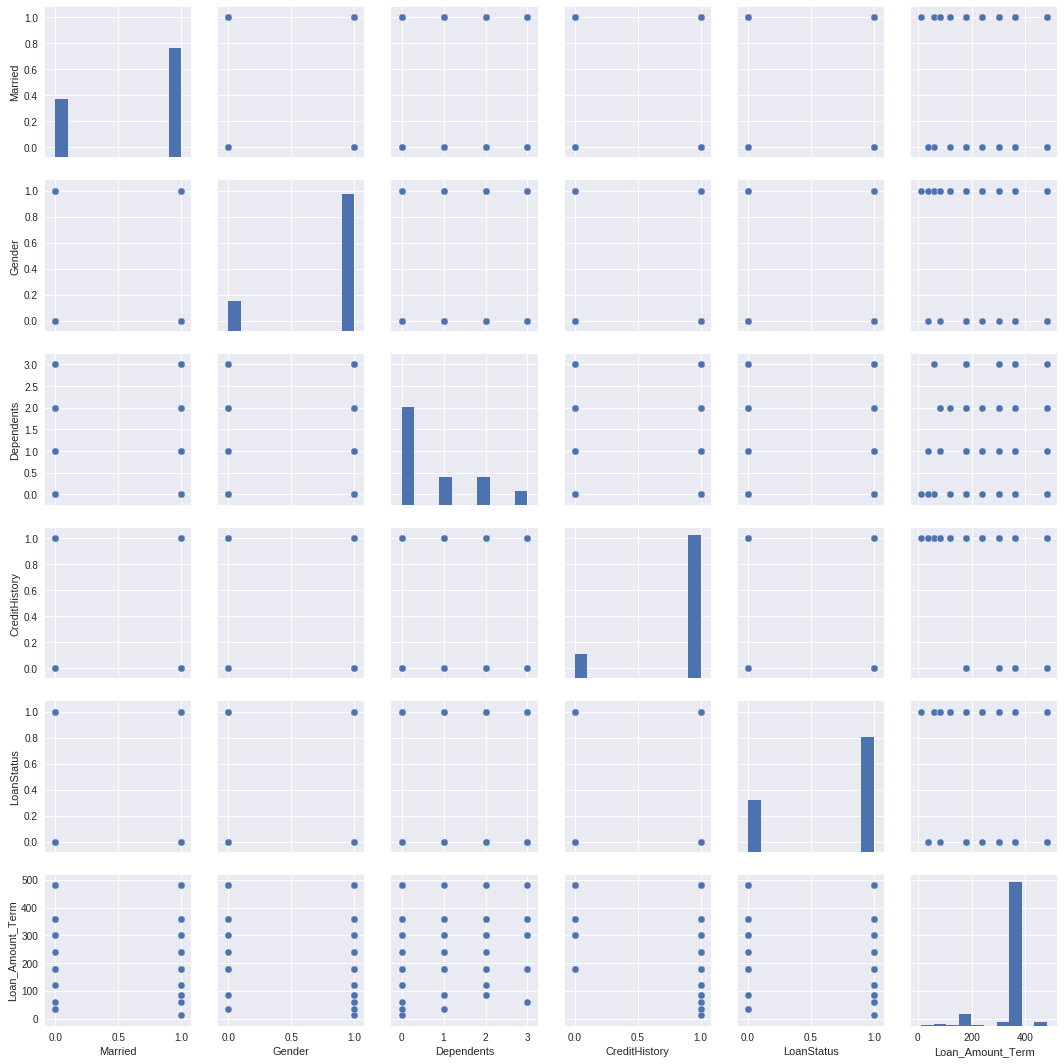

In [213]:
sns.pairplot(data_enc);

From the pairplot, it is clear that no pairs of these categorical features are linearly related, and none of them are normally distributed.

In [226]:
categorical_stats = pd.DataFrame([])
for x1, x2 in zip(['Married', 'Married', 'CreditHistory', 'Gender', 'Loan_Amount_Term', 'Loan_Amount_Term'], 
                  ['Gender', 'Dependents', 'LoanStatus', 'Dependents', 'Dependents', 'Married']):
    M = data_enc[[x1, x2]].as_matrix()
    rho = spearmanr(M)[0]
    
    counts = pd.crosstab(data_f[x1], data_f[x2])
    chi2, pchi = chi2_contingency(counts)[:2]
    
    name = '{} and {}'.format(x1, x2)
    categorical_stats = categorical_stats.append(pd.Series([rho, chi2, pchi], name=name))
        
categorical_stats.columns=["Spearman's Rank Correlation", 'Chi-Square', 'p-value']

categorical_stats

,Spearman's Rank Correlation,Chi-Square,p-value
Married and Gender,0.364569,79.635629,4.502329e-19
Married and Dependents,0.352516,79.268723,4.404384e-17
CreditHistory and LoanStatus,0.540556,176.114575,3.418350e-40
Gender and Dependents,0.168293,19.492019,2.162744e-04
Loan_Amount_Term and Dependents,-0.121601,33.934835,1.679499e-01
Loan_Amount_Term and Married,-0.119930,17.360466,4.336140e-02


**Step 8**: Check for Normality - Check normality by overlaying the 'ECDF' over the 'CDF'.

Reference: https://www.andata.at/en/software-blog-reader/why-we-love-the-cdf-and-do-not-like-histograms-that-much.html

Does the distribution of 'Applicant Income' follow a normal distribution?

Hint: Code Snippet has been provided. Complete the rest of the code.



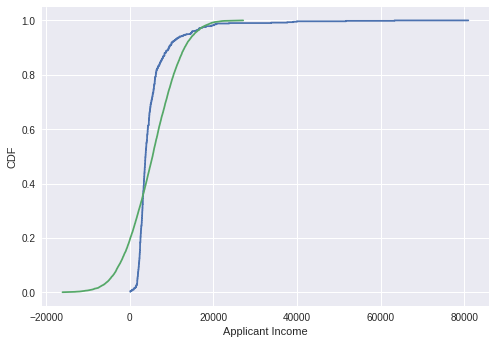

In [230]:
#Function to compute the ECDF
def ECDF(input):
 
    # Number of data points
    n = len(input)
    
    # x_data for the ECDF
    x_data = np.sort(input)

    # y_data for the ECDF
    y_data = np.arange(1, n+1) / n

    return x_data, y_data
  
#Checking the Normality of Data - we will compute the CDF by using np.random.samples to draw samples and then compare with ECDF
income_data = data_f['ApplicantIncome']
mean = np.mean(income_data) 
std = np.std(income_data)

#Draw Samples
samples = np.random.normal(mean, std, size=10000)

#Compute ECDF 
x, y = ECDF(income_data)

#Compute PDF
xn, yn = ECDF(samples)

# Generate plot
plt.step(x, y)
plt.plot(xn, yn)

# Label the axes
plt.xlabel('Applicant Income')
plt.ylabel('CDF')
           
# Show the plot           
plt.show();

#State your conclusion

The data is not normally distributed. Rather, like much of real-life data, it has a [long tail](https://en.wikipedia.org/wiki/Long_tail), and has no values below zero. It is clustered more tightly around lower values than normally distributed data sharing the same standard deviation would be, and its median is also less than its mean, indicating that the data is positively skewed.

**Step 9:** Use Statistical Techniques to make quantitative statements on data. 

What are the chances that the bank fail? 

Let's assume for every 0 to 1000 mortgage loans the bank makes, a certain number of loans will be defaulted on. The probability of a loan default is p = 0.05 The bank will fail if there are greater than 100 defaults.

Hint: Use the techniques applied in Coding Challenge #4




In [247]:
experiments = 10000
fails = 0
for _ in range(experiments):
    defaults = np.sum(np.random.binomial(1000, 0.05))
    if defaults >= 100:
        fails += 1
        
p_fail = fails / experiments

print('A bank will fail with probability {:.2f}'.format(p_fail))

A bank will fail with probability 0.00


When the individual probability of defaulting is only 5% per loan, it is very unlikely for over 100 out of 1000 loans to default. If we increase this failure probability to 10%, we find that banks will fail about half the time.

In [248]:
experiments = 10000
fails = 0
for _ in range(experiments):
    defaults = np.sum(np.random.binomial(1000, 0.1))
    if defaults >= 100:
        fails += 1
        
p_fail = fails / experiments

print('A bank will fail with probability {:.2f}'.format(p_fail))

A bank will fail with probability 0.51


**Step 10**: Publish findings - In this step, you are going to conduct statistical analysis on a dataset from the Data.gov website.

1) Pick a dataset (decent size dataset - approx. 10k to 15K records)

2) Walk through the statistical analysis journey highlighted within this Sprint Challenge

3) Summarize your findings at each step of the statistical analysis journey

4) Conclude your the journey with a brief section providing an overview of your findings

5) Publish your statistical analysis journey as a blog post

6) Include a link to your blog post in your submission



At the time of this sprint challege, I have not yet conducted statistical analysis on another dataset. Instead, I have collected some useful functions from this sprint challenge into a small python module. Over the next couple weeks, I will refine them and standardize their interfaces, automating a lot of the first steps in exploratory data analysis. Once this is done, I will test the module on some unfamiliar datasets and blog about my learnings.

The module is here: https://github.com/rayheberer/quick_stats